<a href="https://colab.research.google.com/github/devimur2021/Automatic-Ticket-Classification-NLP/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [281]:
import pathlib
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [282]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/NLP : Automatic Ticket Classification'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [320]:
# Opening JSON file 
# returns JSON object as  
# a dictionary 
with open('gdrive/My Drive/Colab Notebooks/NLP : Automatic Ticket Classification/complaints.json') as f:
   data = json.load(f)

df=pd.json_normalize(data)

In [321]:
pd.set_option('max_columns', None)
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

In [322]:
# Inspect the dataframe to understand the given data.
print("**********Shape of the dataset********\n")
print(df.shape)

print("\n*********info of the dataset***************\n")
print(df.info(verbose=True,null_counts=True))



**********Shape of the dataset********

(78313, 22)

*********info of the dataset***************



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning:

null_counts is deprecated. Use show_counts instead



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [323]:
#identify Coulmns having missing values
df.isnull().sum(axis=0)

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

In [324]:
#Number of columns having missing value in percentage
round(100*df.isnull().sum()[(df.isnull().sum()> 0)]/len(df), 2)

_source.tags                         86.08
_source.zip_code                      8.63
_source.state                         2.54
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [325]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [326]:
# Drop Columns having ~30% missing values 
df.drop(['_source.tags','_source.zip_code','_source.state','_source.company_public_response','_source.sub_product','_source.sub_issue','_source.consumer_consent_provided'],axis=1,inplace=True)

In [327]:
#print the column names
print(df.columns)
print(df.info(verbose=True,null_counts=True))

Index(['_index', '_type', '_id', '_score', '_source.complaint_id',
       '_source.issue', '_source.date_received', '_source.consumer_disputed',
       '_source.product', '_source.company_response', '_source.company',
       '_source.submitted_via', '_source.date_sent_to_company',
       '_source.timely', '_source.complaint_what_happened'],
      dtype='object')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning:

null_counts is deprecated. Use show_counts instead



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _index                           78313 non-null  object 
 1   _type                            78313 non-null  object 
 2   _id                              78313 non-null  object 
 3   _score                           78313 non-null  float64
 4   _source.complaint_id             78313 non-null  object 
 5   _source.issue                    78313 non-null  object 
 6   _source.date_received            78313 non-null  object 
 7   _source.consumer_disputed        78313 non-null  object 
 8   _source.product                  78313 non-null  object 
 9   _source.company_response         78313 non-null  object 
 10  _source.company                  78313 non-null  object 
 11  _source.submitted_via            78313 non-null  object 
 12  _source.date_sent_

In [328]:
#Assign new column names
newNames = {
    '_index':'index',
    '_type': 'type',
    '_id' : 'id',
    '_score':'score',
    '_source.complaint_id':'compliant_id',
    '_source.issue' : 'issue',
    '_source.date_received':'date_received',
    '_source.consumer_disputed':'consumer_disputed',
    '_source.product':'product',
    '_source.company_response':'company_response',
    '_source.company':'company',
    '_source.submitted_via':'submitted_via',
    '_source.date_sent_to_company':'date_sent_to_company',
    '_source.timely':'timely',
    '_source.complaint_what_happened':'complaint_what_happened'
}
df.rename(columns=newNames,inplace=True)
df.columns

Index(['index', 'type', 'id', 'score', 'compliant_id', 'issue',
       'date_received', 'consumer_disputed', 'product', 'company_response',
       'company', 'submitted_via', 'date_sent_to_company', 'timely',
       'complaint_what_happened'],
      dtype='object')

In [329]:
#Assign nan in place of blanks in the complaints column
#df[df.loc[:, 'complaint_what_happened'] == '']
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan
df['complaint_what_happened']

0                                                      NaN
1        Good morning my name is XXXX XXXX and I apprec...
2        I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                      NaN
4                                                      NaN
                               ...                        
78308                                                  NaN
78309    On Wednesday, XX/XX/XXXX I called Chas, my XXX...
78310    I am not familiar with XXXX pay and did not un...
78311    I have had flawless credit for 30 yrs. I've ha...
78312    Roughly 10+ years ago I closed out my accounts...
Name: complaint_what_happened, Length: 78313, dtype: object

In [330]:
#Remove all rows where complaints column is blank
df.dropna(subset=['complaint_what_happened'],axis=0,inplace=True)
print(df.info(verbose=True,show_counts=True))
df.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21072 entries, 1 to 78312
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    21072 non-null  object 
 1   type                     21072 non-null  object 
 2   id                       21072 non-null  object 
 3   score                    21072 non-null  float64
 4   compliant_id             21072 non-null  object 
 5   issue                    21072 non-null  object 
 6   date_received            21072 non-null  object 
 7   consumer_disputed        21072 non-null  object 
 8   product                  21072 non-null  object 
 9   company_response         21072 non-null  object 
 10  company                  21072 non-null  object 
 11  submitted_via            21072 non-null  object 
 12  date_sent_to_company     21072 non-null  object 
 13  timely                   21072 non-null  object 
 14  complaint_what_happene

,index,type,id,score,compliant_id,issue,date_received,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,timely,complaint_what_happened
1,complaint-public-v2,complaint,3229299,0.0,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,Yes,Good morning my name is XXXX XXXX and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,complaint-public-v2,complaint,3233499,0.0,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,Yes,Chase Card was reported on XX/XX/2019. However...
11,complaint-public-v2,complaint,3180294,0.0,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,Yes,"On XX/XX/2018, while trying to book a XXXX XX..."
14,complaint-public-v2,complaint,3224980,0.0,3224980,Managing an account,2019-04-27T12:00:00-05:00,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,Yes,my grand son give me check for {$1600.00} i de...


In [331]:
# Check if blank values still exist
df[df.loc[:, 'complaint_what_happened'] == '']

,index,type,id,score,compliant_id,issue,date_received,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,timely,complaint_what_happened


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [332]:
# Convert complaint_what_happened column to string for performing text operations
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

In [333]:
# Write your function here to clean the text and remove all the unnecessary elements.

#Convert Lower Case
df['complaint_what_happened'] = df['complaint_what_happened'].str.lower()

#Remove Text in Square brackets
df['complaint_what_happened'] = pd.DataFrame([str(line).strip('{').strip('}') for line in df['complaint_what_happened']])

#Remove Punctuation
df.complaint_what_happened.replace(r'[^\w\s]+','',regex = True,inplace=True)

#Remove Words containing numbers
df.complaint_what_happened.replace(r'[0-9]+','',regex = True,inplace=True)

df.head(5)

,index,type,id,score,compliant_id,issue,date_received,consumer_disputed,product,company_response,company,submitted_via,date_sent_to_company,timely,complaint_what_happened
1,complaint-public-v2,complaint,3229299,0.0,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,Yes,i upgraded my xxxx xxxx card in xxxx and was t...
2,complaint-public-v2,complaint,3199379,0.0,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,Yes,chase card was reported on xxxx however fraudu...
10,complaint-public-v2,complaint,3233499,0.0,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,Yes,mishandling of this account by chase auto and ...
11,complaint-public-v2,complaint,3180294,0.0,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,N/A,"Credit reporting, credit repair services, or o...",Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,Yes,i have reached out to xxxx several times in at...
14,complaint-public-v2,complaint,3224980,0.0,3224980,Managing an account,2019-04-27T12:00:00-05:00,N/A,Checking or savings account,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,Yes,my chase amazon card was declined for a cateri...


In [334]:
df.shape

(21072, 15)

In [ ]:
df_clean = pd.DataFrame(df['complaint_what_happened'])
df_clean

In [336]:
df_clean.shape

(21072, 1)

In [337]:
#Write your function to Lemmatize the texts

def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)


In [339]:
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

ValueError: ignored

In [176]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean

,complaint_what_happened,complaint_lemmatized
1,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...
2,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx
11,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...
...,...,...
21057,un approved charge to my chase checking accoun...,un approve charge to my chase check account \n...
21058,chase bank will not release the funds of the d...,chase bank will not release the fund of the de...
21062,i tried to buy concert tickets from someone on...,I try to buy concert ticket from someone on xx...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...


In [177]:
df_clean.shape

(7125, 2)

In [178]:
# Import Textblob for extracting noun phrases
# !pip install textblob
from textblob import TextBlob

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Installing wordcloud
# !pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Import pickle to save and load the model
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [179]:
#Write your function to extract the POS tags 

def pos_tag(text):
    sent = []
    blob = TextBlob(text)
    sent = [word for (word,tag) in blob.tags if tag=='NN']
    return " ".join(sent)


#This column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] =  df_clean['complaint_lemmatized'].apply(pos_tag)


In [180]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...
2,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx
11,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...
...,...,...,...
21057,un approved charge to my chase checking accoun...,un approve charge to my chase check account \n...,charge check account add trial pill order tria...
21058,chase bank will not release the funds of the d...,chase bank will not release the fund of the de...,chase bank fund deposit check reason check xxx...
21062,i tried to buy concert tickets from someone on...,I try to buy concert ticket from someone on xx...,ticket someone xxxx lot question ask ticket co...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...


In [181]:
df_clean.shape

(7125, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




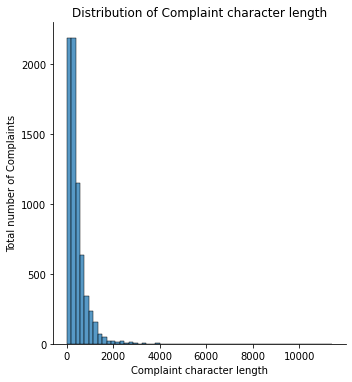

In [182]:
# Write your code here to visualise the data according to the 'Complaint' character length

char_len = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(char_len, kind='hist', bins=60)
plt.xlabel("Complaint character length")
plt.ylabel("Total number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

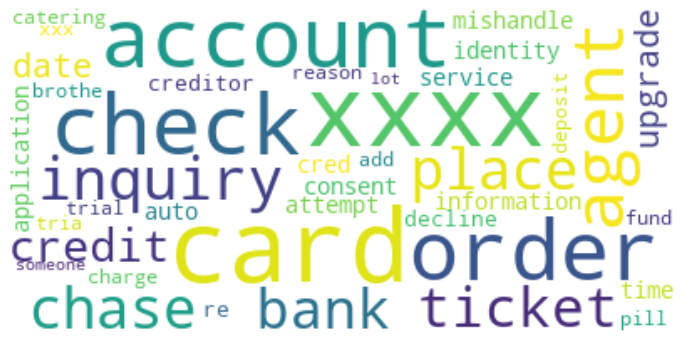

In [183]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=40, 
                      background_color="white", random_state=100, 
                      stopwords=stopwords).generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[12,12])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [184]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [185]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [186]:
#Print the top 30 words in the unigram frequency
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,account,16065
1,chase,15625
2,xxxx,14041
3,credit,11390
4,card,9673
5,bank,9553
6,payment,6774
7,time,5288
8,charge,4945
9,day,4501


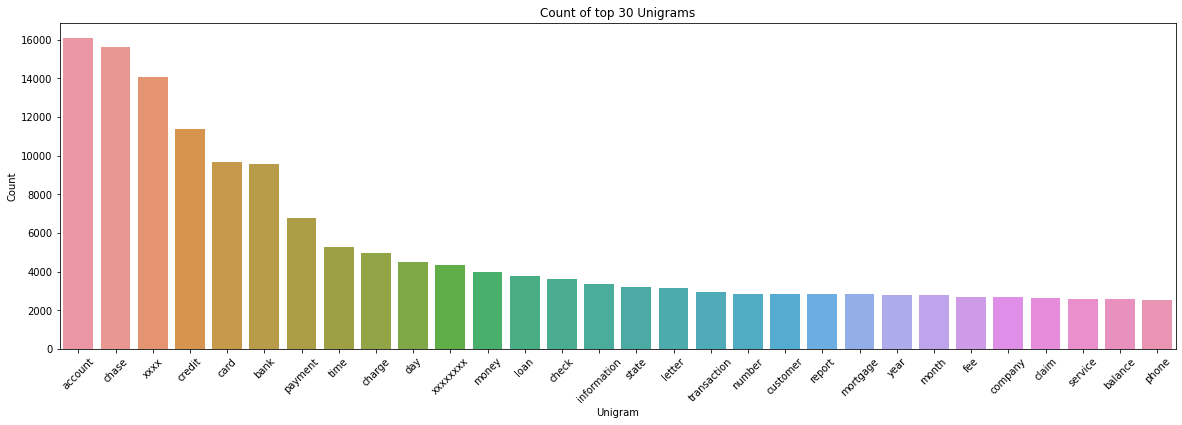

In [187]:
# Plotting top 30 Unigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [188]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,16065
1,chase,15625
2,xxxx,14041
3,credit,11390
4,card,9673
5,bank,9553
6,payment,6774
7,time,5288
8,charge,4945
9,day,4501


In [189]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,4352
1,xxxx xxxx,1478
2,credit report,1282
3,customer service,1066
4,chase credit,1022
5,chase bank,1006
6,bank account,960
7,account chase,898
8,chase account,873
9,account account,783


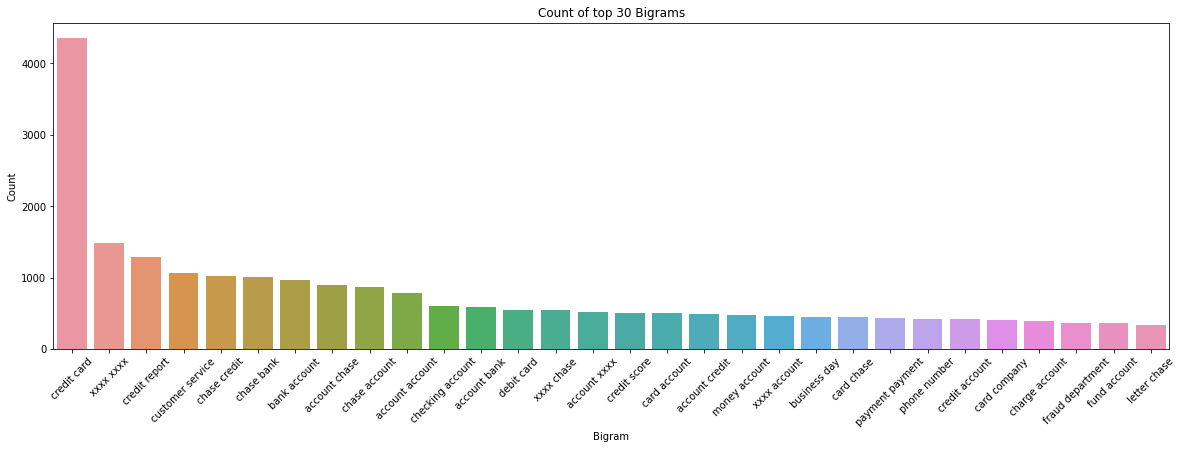

In [190]:
# Plotting top 30 Bigrams
plt.figure(figsize=[20,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [191]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,4352
1,xxxx xxxx,1478
2,credit report,1282
3,customer service,1066
4,chase credit,1022
5,chase bank,1006
6,bank account,960
7,account chase,898
8,chase account,873
9,account account,783


In [192]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_top_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,738
1,credit card company,363
2,credit card account,324
3,credit card chase,226
4,inquiry credit report,175
5,credit card credit,165
6,xxxx xxxx xxxx,157
7,charge credit card,149
8,xxxx credit card,138
9,account credit card,132


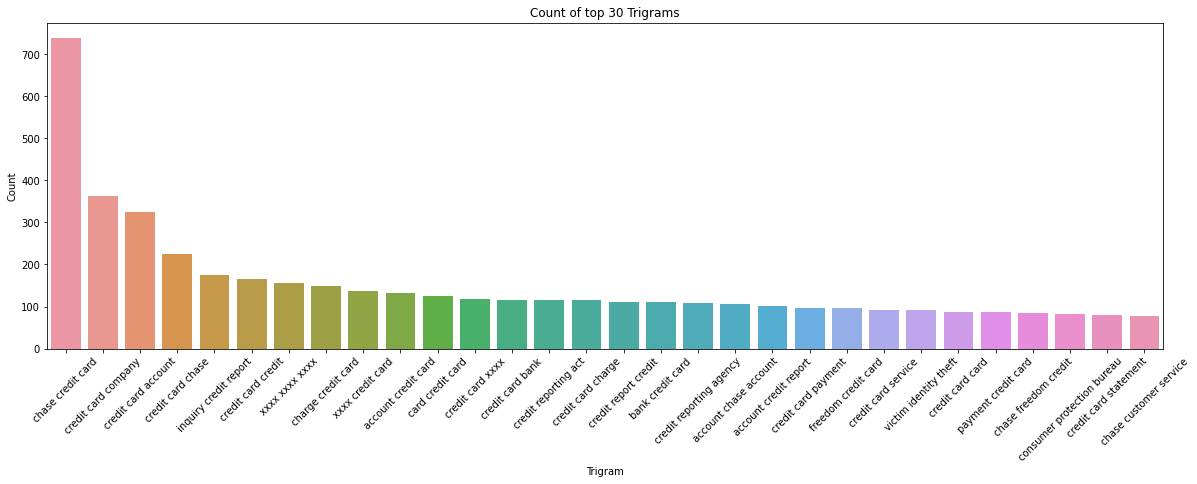

In [193]:
plt.figure(figsize=[20,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

In [194]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,738
1,credit card company,363
2,credit card account,324
3,credit card chase,226
4,inquiry credit report,175
5,credit card credit,165
6,xxxx xxxx xxxx,157
7,charge credit card,149
8,xxxx credit card,138
9,account credit card,132


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [195]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [196]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...
2,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto
11,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,chase card decline catering order place brothe...
...,...,...,...,...
21057,un approved charge to my chase checking accoun...,un approve charge to my chase check account \n...,charge check account add trial pill order tria...,charge check account add trial pill order tria...
21058,chase bank will not release the funds of the d...,chase bank will not release the fund of the de...,chase bank fund deposit check reason check xxx...,chase bank fund deposit check reason check fu...
21062,i tried to buy concert tickets from someone on...,I try to buy concert ticket from someone on xx...,ticket someone xxxx lot question ask ticket co...,ticket someone lot question ask ticket confir...
21068,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...


In [197]:
df_clean.shape

(7125, 4)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [198]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [199]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
dtm

<7125x4451 sparse matrix of type '<class 'numpy.float64'>'
	with 216143 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [200]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [201]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [202]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



4451

In [203]:
#Print the Top15 words for each of the topics
H = nmf_model.components_ 

words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,check,money,fund,chase,deposit,day,branch,checking,business,transaction,number,customer,transfer
Topic 2,credit,card,report,inquiry,chase,account,company,score,information,application,limit,debt,year,letter,balance
Topic 3,loan,mortgage,home,modification,chase,property,year,rate,time,letter,bank,house,document,foreclosure,sale
Topic 4,charge,card,dispute,transaction,chase,fee,merchant,claim,purchase,fraud,service,statement,refund,time,company
Topic 5,payment,balance,month,fee,statement,auto,day,date,time,pay,credit,account,chase,year,plan


Observation Looking at the topics above, for each topic, we can give a label based on their products/services:

Topic 1 = Bank account services

Topic 2 = Credit card / Prepaid card

Topic 3 = Others

Topic 4 = Theft/Dispute reporting

Topic 5 = Mortgages/loans

In [204]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(dtm)

In [205]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1)

In [206]:
df_clean.head(10)
df_clean.shape

(7125, 5)

In [212]:
#Print the first 5 Complaint for each of the Topics
df_topic=df_clean.groupby('Topic').head(5)
df_topic.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,Bank account services
15,i opened the saving account for the bonus i w...,I open the saving account for the bonus I be...,account bonus bonus auto transfer check xxxx t...,account bonus bonus auto transfer check trans...,Bank account services
17,my card went missing and i didnt realize it un...,my card go missing and I do not realize it unt...,card today email money bank account,card today email money bank account,Bank account services
52,on xxxx i made a deposit into my chase bank pe...,on xxxx I make a deposit into my chase bank pe...,xxxx deposit chase bank checking account amoun...,deposit chase bank checking account amount bu...,Bank account services
45,i advised chase of the billing error for goods...,I advise chase of the billing error for good a...,chase billing error service chase refuse claim...,chase billing error service chase refuse claim...,Bank account services
1,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...,Credit card / Prepaid card
2,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,Credit card / Prepaid card
11,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,Credit card / Prepaid card
20,jp morgan chase bank please answer the followi...,jp morgan chase bank please answer the follow ...,jp bank please question xxxxxxxx access inform...,jp bank please question access information re...,Credit card / Prepaid card
21,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen company xxxx time share company nothin...,citizen company time share company nothing re...,Credit card / Prepaid card


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [208]:
df_clean.head(5)

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...,1
2,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,1
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
11,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,1
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,chase card decline catering order place brothe...,3


In [209]:
#Create the dictionary of Topic names and Topics
Topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",
               3:"Theft/Dispute reporting", 4:"Mortgages/loans" }

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [210]:
df_clean.head(10)

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,i upgraded my xxxx xxxx card in xxxx and was t...,I upgrade my xxxx xxxx card in xxxx and be tel...,card xxxx agent upgrade date agent information...,card agent upgrade date agent information ord...,Credit card / Prepaid card
2,chase card was reported on xxxx however fraudu...,chase card be report on xxxx however fraudulen...,card application identity consent service cred...,card application identity consent service cred...,Credit card / Prepaid card
10,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,Bank account services
11,i have reached out to xxxx several times in at...,I have reach out to xxxx several time in attem...,time attempt inquiry creditor place inquiry re...,time attempt inquiry creditor place inquiry re...,Credit card / Prepaid card
14,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card decline catering order place brothe...,chase card decline catering order place brothe...,Theft/Dispute reporting
15,i opened the saving account for the bonus i w...,I open the saving account for the bonus I be...,account bonus bonus auto transfer check xxxx t...,account bonus bonus auto transfer check trans...,Bank account services
17,my card went missing and i didnt realize it un...,my card go missing and I do not realize it unt...,card today email money bank account,card today email money bank account,Bank account services
20,jp morgan chase bank please answer the followi...,jp morgan chase bank please answer the follow ...,jp bank please question xxxxxxxx access inform...,jp bank please question access information re...,Credit card / Prepaid card
21,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,citizen company xxxx time share company nothin...,citizen company time share company nothing re...,Credit card / Prepaid card
23,i have been trying to do a loan modification w...,I have be try to do a loan modification with c...,loan modification chase runaround payment doc,loan modification chase runaround payment doc,Others


In [211]:
df_clean.shape

(25, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [142]:
#Create the dictionary again of Topic names and Topics
Topic_names = { "Bank account services":0, "Credit card / Prepaid card":1, "Others":2,
               "Theft/Dispute reporting":3, "Mortgages/loans":4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [146]:
df_clean.head

<bound method NDFrame.head of                                complaint_what_happened  \
1    i upgraded my xxxx xxxx card in xxxx and was t...   
2    chase card was reported on xxxx however fraudu...   
10   mishandling of this account by chase auto and ...   
11   i have reached out to xxxx several times in at...   
14   my chase amazon card was declined for a cateri...   
15   i opened the saving account for the  bonus i w...   
17   my card went missing and i didnt realize it un...   
20   jp morgan chase bank please answer the followi...   
21   i am a senior citizen that has been scammed by...   
23   i have been trying to do a loan modification w...   
24   i made a purchase of  on xxxxxxxx i made payme...   
26   i tried to send almost  at xxxx and the transa...   
30   i have wired through one of chase branches in ...   
32   i bought a new xxxx xxxx on xxxxxxxx from xxxx...   
43   i purchase is an airline ticket on xxxxxxxx an...   
45   i advised chase of the billing error 

In [147]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [148]:
training_data

,complaint_what_happened,Topic
1,i upgraded my xxxx xxxx card in xxxx and was t...,1
2,chase card was reported on xxxx however fraudu...,1
10,mishandling of this account by chase auto and ...,0
11,i have reached out to xxxx several times in at...,1
14,my chase amazon card was declined for a cateri...,3
15,i opened the saving account for the bonus i w...,0
17,my card went missing and i didnt realize it un...,0
20,jp morgan chase bank please answer the followi...,1
21,i am a senior citizen that has been scammed by...,1
23,i have been trying to do a loan modification w...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [151]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
#Write your code to get the Vector count
vect = CountVectorizer()
X_train_cnt = vect.fit_transform(training_data['complaint_what_happened'])

# Save word vector
pickle.dump(vect.vocabulary_, open("count_vector.pk1", "wb"))

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cnt)

# Save tfidf
pickle.dump(tfidf_transformer, open('tfidf.pk1', "wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [152]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression
# Importing Train, Test Split
from sklearn.model_selection import train_test_split

In [153]:
# Train, Test Split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.25, random_state=42)

In [154]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

In [155]:
# Getting the score of the base model
logreg.score(X_test, y_test)

0.0